In [1]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime

In [115]:
dataset = h5py.File('simu_HDF.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-1,:,:] #redefine the shape and size of histgrid by removing the last xy position "342" because it is bad
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

values = [111, 98, 67, 66, 133, 75, 46, 121, 110, 109, 84, 131, 17, 88, 8, 85, 100, 105, 115, 108, 80, 104, 76, 93, 286, 128, 134, 84, 132, 119, 118, 174, 324, 102, 129, 168, 176, 120, 144]
#list of locations (by index) in histgrid which have unusable data due to peaks being in incorrect locations

#new_histgrid = np.delete(histgrid[:], values, axis=0)
#histgrid = new_histgrid
print(output[0])

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with 342 removed
histgrid[where_are_NaNs] = 0

dataset.close()

[-12. -12.]


In [3]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts xy pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(341000, 132)
(341000, 2)


In [4]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

1.0


In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [6]:
train_data.ndim

2

In [7]:
train_data.shape

(272800, 132)

In [8]:
train_data[0]

array([0.        , 0.0034329 , 0.0034329 , 0.        , 0.        ,
       0.        , 0.0034329 , 0.        , 0.06179222, 0.11328573,
       0.14418184, 0.20940696, 0.15104764, 0.09268833, 0.04806061,
       0.0068658 , 0.0068658 , 0.0068658 , 0.        , 0.0034329 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0034329 ,
       0.0068658 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0068658 , 0.        ,
       0.        , 0.0068658 , 0.0034329 , 0.09955413, 0.61105638,
       0.10985283, 0.0034329 , 0.        , 0.        , 0.        ,
       0.0034329 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0034329 , 0.        ,
       0.        , 0.        , 0.0068658 , 0.        , 0.        ,
       0.0068658 , 0.0102987 , 0.0102987 , 0.08925543, 0.17507795,
       0.3226927 , 0.20597406, 0.13388314, 0.05149352, 0.     

In [9]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [10]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.1))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [11]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [12]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=20,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/20
5968/5968 [==============================] - 21s 3ms/step - loss: 20.2453 - mae: 2.5255 - mse: 20.2453 - val_loss: 2.9205 - val_mae: 1.2429 - val_mse: 2.9205
Epoch 2/20
5968/5968 [==============================] - 17s 3ms/step - loss: 2.4517 - mae: 1.1251 - mse: 2.4517 - val_loss: 1.9836 - val_mae: 0.9954 - val_mse: 1.9836
Epoch 3/20
5968/5968 [==============================] - 22s 4ms/step - loss: 1.7168 - mae: 0.9394 - mse: 1.7168 - val_loss: 1.6600 - val_mae: 0.9198 - val_mse: 1.6600
Epoch 4/20
5968/5968 [==============================] - 16s 3ms/step - loss: 1.3845 - mae: 0.8391 - mse: 1.3845 - val_loss: 1.4902 - val_mae: 0.8825 - val_mse: 1.4902
Epoch 5/20
5968/5968 [==============================] - 17s 3ms/step - loss: 1.1881 - mae: 0.7734 - mse: 1.1881 - val_loss: 1.1721 - val_mae: 0.7627 - val_mse: 1.1721
Epoch 6/20
5968/5968 [==============================] - 17s 3ms/step - loss: 1.0585 - mae: 0.7256 - mse: 1.0585 - val_loss: 1.0610 - val_mae: 0.7197 - val_mse: 1.0

Text(0.5, 1.0, 'FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation')

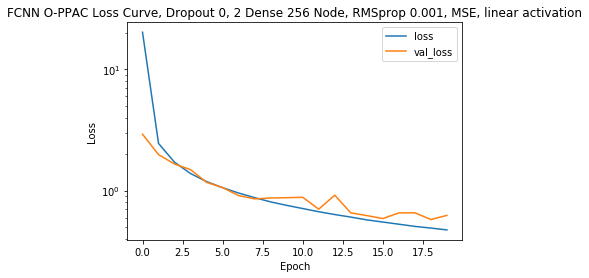

In [73]:
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation")

In [75]:
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2132/2132 - 5s - loss: 0.5653 - mae: 0.5215 - mse: 0.5653


In [74]:
predictions = FCNN_model.predict(test_data)

In [56]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = [i[0] for i in test_labels]
y_test1 = [i[1] for i in test_labels]

x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test[0]
y_test[0]


print(np.min(x_pred))
print(np.min(y_pred))

-41.7996
-42.51116


In [64]:
#to find the locations of largest error within my predicted x values
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = abs(x_pred[i] - x_test[i])
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if i >= 3]
error_list_x.sort(reverse = True)
print(len(error_list_x))
print(error_list_x)

#plt.axis([0, 60000, 0, 5])
#plt.plot(x_error)

279
[20.54350471496582, 18.861065983772278, 17.655179977416992, 16.484895706176758, 16.04187060892582, 14.438444137573242, 11.088207244873047, 10.968460083007812, 10.855917930603027, 10.083949089050293, 9.649027824401855, 8.50429916381836, 8.425709247589111, 7.828568458557129, 7.656353950500488, 7.565105438232422, 7.261567115783691, 6.9906182289123535, 6.916011810302734, 6.535188674926758, 6.510931015014648, 6.356080532073975, 6.345834732055664, 6.237142562866211, 6.2305450439453125, 6.207411289215088, 6.148230075836182, 6.002338409423828, 5.996770858764648, 5.943127155303955, 5.8760986328125, 5.871228218078613, 5.852285385131836, 5.846264839172363, 5.82188606262207, 5.803887844085693, 5.803840637207031, 5.802990913391113, 5.800264835357666, 5.768074035644531, 5.735206604003906, 5.66944694519043, 5.664102077484131, 5.65855598449707, 5.583623886108398, 5.534226417541504, 5.5149688720703125, 5.5133256912231445, 5.511144161224365, 5.401029586791992, 5.392724990844727, 5.3858137130737305, 

In [53]:
location = []
for i in error_list_x:
    x_locat = np.where(x_pos == (np.array(x_test[x_error.index(i)])))
    y_locat = np.where(y_pos == (np.array(y_test[x_error.index(i)])))
    locat = np.intersect1d(x_locat, y_locat)
    for l in locat:
        location += l
        
    location.sort()
    print(location)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [65]:
#in "bad value" plug in error value to find the index for x_pos and y_pos
bad_value = 20.54350471496582
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

#the common value between the x and y arrays is the index of the bad data

[309]


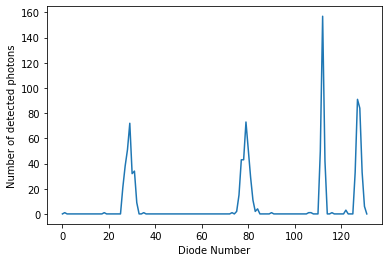

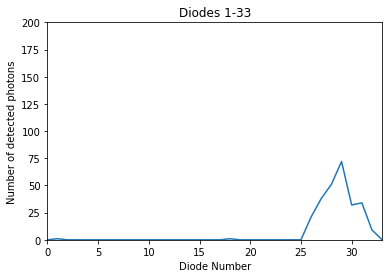

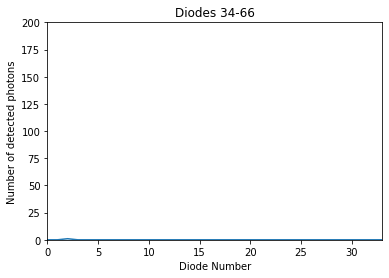

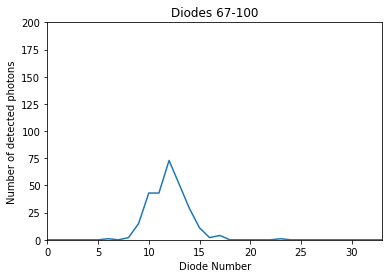

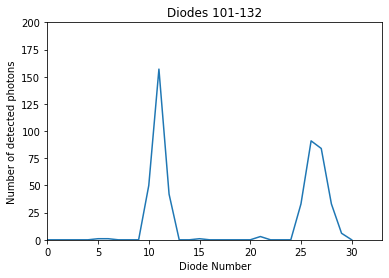

In [98]:
#bad_locat is the index location of the bad data (integer between 0 and 341)
bad_locat = 80

#test_data_value is from 0 to 1000; pick one of the 1001 simulated events for that location
#bad data could appear at any of these, given the bad index
test_data_value = 500

test_histogram = []
for i in range(132):
    test_histogram.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram)

#plt.axis([0, 132, 0, 160])
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.plot(test_histogram)
plt.show()

test_histogram1 = []
for i in range(34):
    test_histogram1.append(histgrid[bad_locat][i][test_data_value])  
np.array(test_histogram1)
 
plt.title('Diodes 1-33')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram1)
plt.show()

test_histogram2 = []
for i in range(33,67):
    test_histogram2.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram2)

plt.title('Diodes 34-66')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram2)
plt.show()

test_histogram3 = []
for i in range(67,101):
    test_histogram3.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram3)

plt.title('Diodes 67-100')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram3)
plt.show()

test_histogram4 = []
for i in range(101,132):
    test_histogram4.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram4)

plt.title('Diodes 101-132')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram4)
plt.show()